In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                  

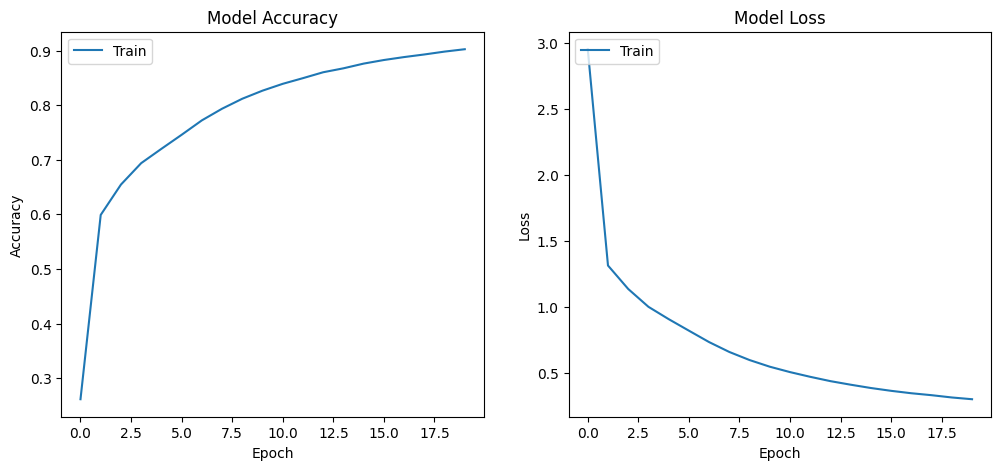

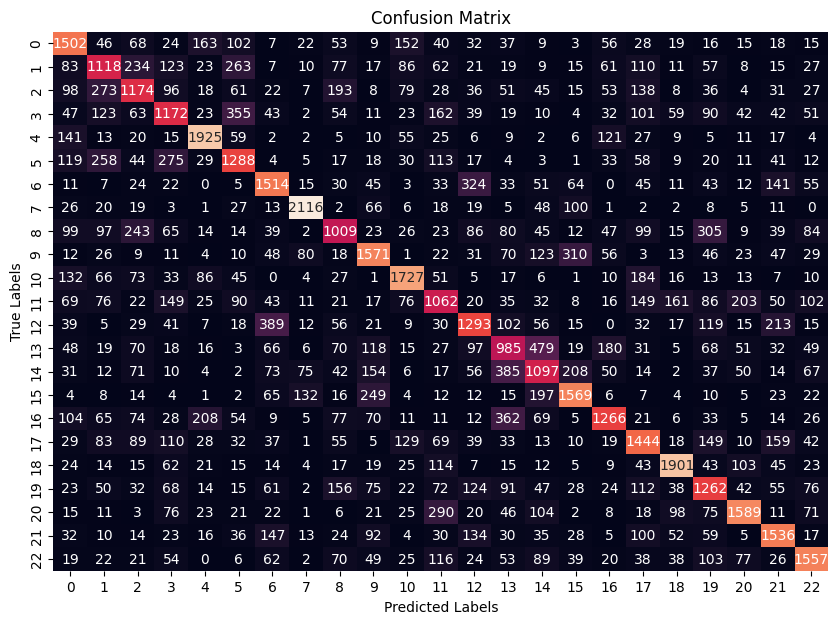

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved trained model at ./doodle.h5 


In [ ]:
import h5py
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow.keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
import io
import os
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import math


h5_file_path1 = '/content/drive/MyDrive/datasets/QuickDrawImages21.h5'
h5_file_path2 = '/content/drive/MyDrive/datasets/QuickDrawImages22.h5'
h5_file_path3 = '/content/drive/MyDrive/datasets/QuickDrawImages23.h5'
h5_file_path4 = '/content/drive/MyDrive/datasets/QuickDrawImages24.h5'
h5_file_path5 = '/content/drive/MyDrive/datasets/QuickDrawImages25.h5'

desired_images = {
    "202": "onion",
    "204": "owl",
    "208": "panda",
    "212": "parrot",
    "215": "pear",
    "218": "penguin",
    "220": "pickup_truck",
    "221": "picture_frame",
    "222": "pig",
    "223": "pillow",
    "224": "pineapple",
    "226": "pliers",
    "227": "police_car",
    "231": "postcard",
    "232": "potato",
    "235": "rabbit",
    "240": "rake",
    "242": "rhinoceros",
    "245": "rollerskates",
    "248": "saw"
    }

# Category meanings
# 1: animal
# 2: bird
# 3: healthyfood
# 4: rectangle
# 5: tool
# 6: vehicle

categories = {
    "onion": 3,
    "owl": 2,
    "panda": 1,
    "parrot": 2,
    "pear": 3,
    "penguin": 2,
    "pickup_truck": 6,
    "picture_frame": 4,
    "pig": 1,
    "pillow": 4,
    "pineapple": 3,
    "pliers": 5,
    "police_car": 6,
    "postcard": 4,
    "potato": 3,
    "rabbit": 1,
    "rake": 5,
    "rhinoceros": 1,
    "rollerskates": 6,
    "saw": 5
}

# This function justifies the doodle centrally within the image
def centre_object(image):
    top_padding = 0
    bottom_padding = 0
    left_padding = 0
    right_padding = 0
    
    # Look for completely black rows at top and bottom
    for row in image:
        if np.sum(row) == 0:
            top_padding += 1
        else:
            break
    for row in np.flipud(image):
        if np.sum(row) == 0:
            bottom_padding += 1
        else:
            break
    
    # Justify image vertically
    if top_padding > bottom_padding + 1:
        to_shift = math.floor((top_padding - bottom_padding)/2)
        image = np.vstack((image[to_shift:, :], image[:to_shift, :]))
    if bottom_padding > top_padding + 1:
        to_shift = math.floor((bottom_padding - top_padding)/2)
        image = np.vstack((image[-1*to_shift:, :], image[:-1*to_shift, :]))

    # Look for completely black rows at left and right
    for col in image.T:
        if np.sum(col) == 0:
            left_padding += 1
        else:
            break
    for col in np.flipud(image.T):
        if np.sum(col) == 0:
            right_padding += 1
        else:
            break

    # Justify image horizontally
    if left_padding > right_padding + 1:
        to_shift = math.floor((left_padding - right_padding)/2)
        image = np.hstack((image[:, to_shift:], image[:, :to_shift]))
    if right_padding > left_padding + 1:
        to_shift = math.floor((right_padding - left_padding)/2)
        image = np.hstack((image[:, -1*to_shift:], image[:, :-1*to_shift]))

    return image

# This function adds the images with targets to X and y, from a h5 file with images aimed at specified targets
# There is a skip parameter - for every image that is added, that many images are skipped
def add_desired_images(file_path, target_range_start, target_range_end, images_per_target, X, y, skip=0, centre_images=False, convert_to_category=False, desired_images=desired_images):
    with h5py.File(file_path, 'r') as h5_file:
        if 'images' in h5_file:
            images_dataset = h5_file['images']
            image_index = 0
            for target in range(target_range_start, target_range_end):
                if str(target) in desired_images:
                    for i in range(images_per_target):
                        # figure += 1
                        if centre_images:
                            X.append(centre_object(images_dataset[image_index]))
                        else:
                            X.append(images_dataset[image_index])
                        if convert_to_category:
                            y.append(categories[desired_images[str(target)]])
                        else:
                            y.append(target)
                        image_index += 1 + skip
                        # If the rest of the images for the target are skipped, move to the next target
                        if image_index % images_per_target < skip:
                            break
                else:
                    image_index += images_per_target
            print(f"File {file_path} parsing complete")
        else:
            print("Image dataset not found!")
    return(X,y)

# This runs the CNN, with some preset parameters
def runCNN(X, y, input_shape, test_size=0.25, random_state=42, kernel_size=(3,3), strides=1, pool_size=(2,2), dense=128, epochs=12):
    # # Split into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=random_state)
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)

    print(X_train[0][0])

    num_classes = y.shape[1]

    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=kernel_size, strides=1, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Flatten())
    model.add(Dense(dense))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train,y_train,verbose=2,epochs=epochs)

    pred_hot = model.predict(X_test)
    pred = np.argmax(pred_hot,axis=1)
    y_compare = np.argmax(y_test,axis=1) 
    score = metrics.accuracy_score(y_compare, pred)

    print("Accuracy score: {}".format(score))

    print(pred_hot[:5])
    print(pred)

    return history

# These are arrays for images and targets respectively
X = []
y = []

# # We ran an initial CNN on our doodle dataset
# X,y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path2, 210, 220, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path3, 220, 230, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path4, 230, 240, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path5, 240, 250, 10000, X, y, 5, False, False)
# raw_y = y
# y = tensorflow.keras.utils.to_categorical(y)
# initial_model = runCNN(X, y, (96, 96, 1))

# # We then ran a CNN after preprocessing the images centrally, leading to a 3% increase in accuracy
# X = []
# y = []
# X,y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path2, 210, 220, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path3, 220, 230, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path4, 230, 240, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path5, 240, 250, 10000, X, y, 5, True, False)
# raw_y = y
# y = tensorflow.keras.utils.to_categorical(y)
# preprocessed_model = runCNN(X, y, (96, 96, 1))

# We then ran a CNN which classifies objects into categories
X = []
y = []
X,y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 5, True, True)
X,y = add_desired_images(h5_file_path2, 210, 220, 10000, X, y, 5, True, True)
X,y = add_desired_images(h5_file_path3, 220, 230, 10000, X, y, 5, True, True)
X,y = add_desired_images(h5_file_path4, 230, 240, 10000, X, y, 5, True, True)
X,y = add_desired_images(h5_file_path5, 240, 250, 10000, X, y, 5, True, True)
raw_y = y
y = tensorflow.keras.utils.to_categorical(y)
category_model = runCNN(X, y, (96, 96, 1))

# Plot
plt.figure(figsize=(12, 5))

# Subplot for training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Subplot for training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

plt.show()

# Confusion matrix
mat = confusion_matrix(y_compare, pred)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(mat, annot=True, fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save model and weights
save_dir = './'
model_name = 'doodle.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Epoch 1/20
4852/4852 [==============================] - 48s 9ms/step - loss: 3.0488 - accuracy: 0.2436 - val_loss: 1.4771 - val_accuracy: 0.5478
Epoch 2/20
4852/4852 [==============================] - 34s 7ms/step - loss: 1.2092 - accuracy: 0.6338 - val_loss: 1.1857 - val_accuracy: 0.6409
Epoch 3/20
4852/4852 [==============================] - 36s 7ms/step - loss: 0.9510 - accuracy: 0.7109 - val_loss: 1.1545 - val_accuracy: 0.6554
Epoch 4/20
4852/4852 [==============================] - 36s 7ms/step - loss: 0.7828 - accuracy: 0.7596 - val_loss: 1.2550 - val_accuracy: 0.6492
Epoch 5/20
4852/4852 [==============================] - 34s 7ms/step - loss: 0.6521 - accuracy: 0.7982 - val_loss: 1.3432 - val_accuracy: 0.6358
Epoch 6/20
4852/4852 [==============================] - 35s 7ms/step - loss: 0.5534 - accuracy: 0.8261 - val_loss: 1.5490 - val_accuracy: 0.6249
Epoch 6: early stopping
Model: "sequential"
_________________________________________________________________
 Layer (type)       

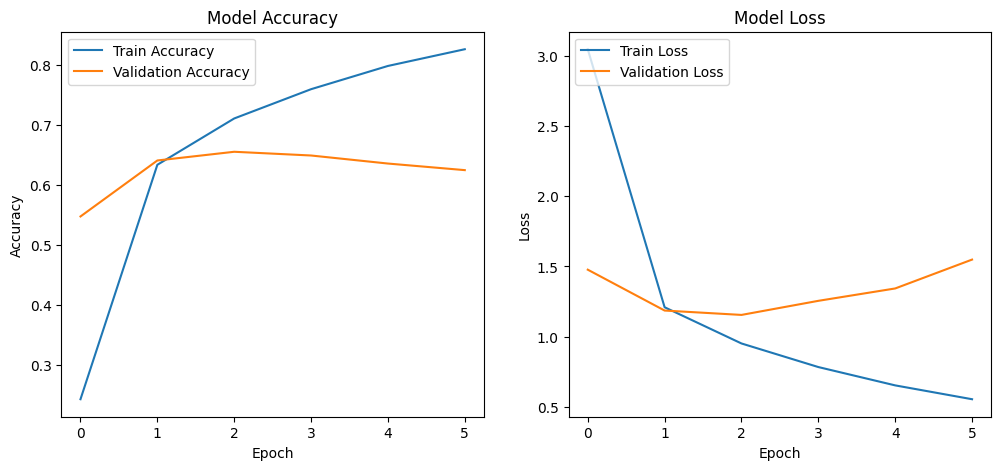

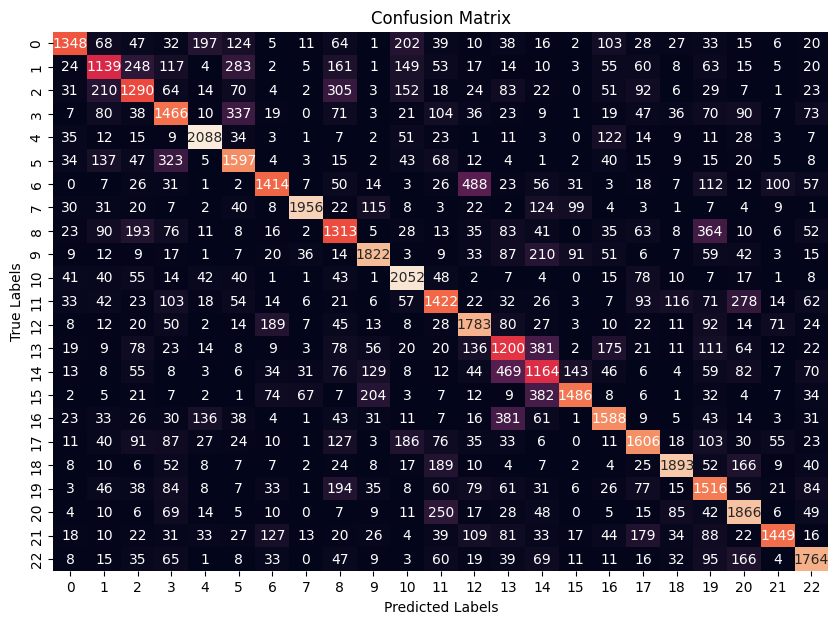

NameError: name 'save_dir' is not defined

In [ ]:
import h5py
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow.keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
import io
import os
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import math


h5_file_path1 = '/content/drive/MyDrive/datasets/QuickDrawImages21.h5'
h5_file_path2 = '/content/drive/MyDrive/datasets/QuickDrawImages22.h5'
h5_file_path3 = '/content/drive/MyDrive/datasets/QuickDrawImages23.h5'
h5_file_path4 = '/content/drive/MyDrive/datasets/QuickDrawImages24.h5'
h5_file_path5 = '/content/drive/MyDrive/datasets/QuickDrawImages25.h5'

desired_images = {
    "202": "onion",
    "204": "owl",
    "208": "panda",
    "212": "parrot",
    "215": "pear",
    "218": "penguin",
    "220": "pickup_truck",
    "221": "picture_frame",
    "222": "pig",
    "223": "pillow",
    "224": "pineapple",
    "226": "pliers",
    "227": "police_car",
    "231": "postcard",
    "232": "potato",
    "235": "rabbit",
    "240": "rake",
    "242": "rhinoceros",
    "245": "rollerskates",
    "248": "saw"
    }

# Category meanings
# 1: animal
# 2: bird
# 3: healthyfood
# 4: rectangle
# 5: tool
# 6: vehicle

categories = {
    "onion": 3,
    "owl": 2,
    "panda": 1,
    "parrot": 2,
    "pear": 3,
    "penguin": 2,
    "pickup_truck": 6,
    "picture_frame": 4,
    "pig": 1,
    "pillow": 4,
    "pineapple": 3,
    "pliers": 5,
    "police_car": 6,
    "postcard": 4,
    "potato": 3,
    "rabbit": 1,
    "rake": 5,
    "rhinoceros": 1,
    "rollerskates": 6,
    "saw": 5
}

# This function justifies the doodle centrally within the image
def centre_object(image):
    top_padding = 0
    bottom_padding = 0
    left_padding = 0
    right_padding = 0
    
    # Look for completely black rows at top and bottom
    for row in image:
        if np.sum(row) == 0:
            top_padding += 1
        else:
            break
    for row in np.flipud(image):
        if np.sum(row) == 0:
            bottom_padding += 1
        else:
            break
    
    # Justify image vertically
    if top_padding > bottom_padding + 1:
        to_shift = math.floor((top_padding - bottom_padding)/2)
        image = np.vstack((image[to_shift:, :], image[:to_shift, :]))
    if bottom_padding > top_padding + 1:
        to_shift = math.floor((bottom_padding - top_padding)/2)
        image = np.vstack((image[-1*to_shift:, :], image[:-1*to_shift, :]))

    # Look for completely black rows at left and right
    for col in image.T:
        if np.sum(col) == 0:
            left_padding += 1
        else:
            break
    for col in np.flipud(image.T):
        if np.sum(col) == 0:
            right_padding += 1
        else:
            break

    # Justify image horizontally
    if left_padding > right_padding + 1:
        to_shift = math.floor((left_padding - right_padding)/2)
        image = np.hstack((image[:, to_shift:], image[:, :to_shift]))
    if right_padding > left_padding + 1:
        to_shift = math.floor((right_padding - left_padding)/2)
        image = np.hstack((image[:, -1*to_shift:], image[:, :-1*to_shift]))

    return image

# This function adds the images with targets to X and y, from a h5 file with images aimed at specified targets
# There is a skip parameter - for every image that is added, that many images are skipped
def add_desired_images(file_path, target_range_start, target_range_end, images_per_target, X, y, skip=0, centre_images=False, convert_to_category=False, desired_images=desired_images):
    with h5py.File(file_path, 'r') as h5_file:
        if 'images' in h5_file:
            images_dataset = h5_file['images']
            image_index = 0
            for target in range(target_range_start, target_range_end):
                if str(target) in desired_images:
                    for i in range(images_per_target):
                        # figure += 1
                        if centre_images:
                            X.append(centre_object(images_dataset[image_index]))
                        else:
                            X.append(images_dataset[image_index])
                        if convert_to_category:
                            y.append(categories[desired_images[str(target)]])
                        else:
                            y.append(target)
                        image_index += 1 + skip
                        # If the rest of the images for the target are skipped, move to the next target
                        if image_index % images_per_target < skip:
                            break
                else:
                    image_index += images_per_target
            print(f"File {file_path} parsing complete")
        else:
            print("Image dataset not found!")
    return(X,y)

# This runs the CNN, with some preset parameters
def runCNN(X, y, input_shape, test_size=0.25, random_state=42, kernel_size=(3,3), strides=1, pool_size=(2,2), dense=128, epochs=12):
    # # Split into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,random_state=random_state)
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)

    print(X_train[0][0])

    num_classes = y.shape[1]

    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=kernel_size, strides=1, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Flatten())
    model.add(Dense(dense))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    model.summary()

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2)
    
    # Train the model with a validation split and early stopping to prevent overfitting
    history = model.fit(X_train, y_train, epochs=epochs, verbose=2, validation_split=0.1, callbacks=[early_stopping])


    # Evaluate model accuracy
    pred_hot = model.predict(X_test)
    pred = np.argmax(pred_hot, axis=1)
    y_compare = np.argmax(y_test, axis=1)
    score = accuracy_score(y_compare, pred)
    print("Accuracy score: {}".format(score))

    print(pred_hot[:5])
    print(pred)

    return history

# These are arrays for images and targets respectively
X = []
y = []

# # We ran an initial CNN on our doodle dataset
# X,y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path2, 210, 220, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path3, 220, 230, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path4, 230, 240, 10000, X, y, 5, False, False)
# X,y = add_desired_images(h5_file_path5, 240, 250, 10000, X, y, 5, False, False)
# raw_y = y
# y = tensorflow.keras.utils.to_categorical(y)
# initial_model = runCNN(X, y, (96, 96, 1))

# # We then ran a CNN after preprocessing the images centrally, leading to a 3% increase in accuracy
# X = []
# y = []
# X,y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path2, 210, 220, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path3, 220, 230, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path4, 230, 240, 10000, X, y, 5, True, False)
# X,y = add_desired_images(h5_file_path5, 240, 250, 10000, X, y, 5, True, False)
# raw_y = y
# y = tensorflow.keras.utils.to_categorical(y)
# preprocessed_model = runCNN(X, y, (96, 96, 1))

# We then ran a CNN which classifies objects into categories
X = []
y = []
X,y = add_desired_images(h5_file_path1, 200, 210, 10000, X, y, 5, True, True)
X,y = add_desired_images(h5_file_path2, 210, 220, 10000, X, y, 5, True, True)
X,y = add_desired_images(h5_file_path3, 220, 230, 10000, X, y, 5, True, True)
X,y = add_desired_images(h5_file_path4, 230, 240, 10000, X, y, 5, True, True)
X,y = add_desired_images(h5_file_path5, 240, 250, 10000, X, y, 5, True, True)
raw_y = y
y = tensorflow.keras.utils.to_categorical(y)
category_model = runCNN(X, y, (96, 96, 1))

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# plot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Confusion matrix
mat = confusion_matrix(y_compare, pred)
plt.figure(figsize=(10, 7))
sns.heatmap(mat, annot=True, fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Save the model
save_dir = './'
model_name = 'doodle.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved')


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.
